## Stock Prices Prediction Using Machine Learning and Deep Learning Techniques

In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv("./SPY1.csv")

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-12-31,146.84375,147.50000,146.250000,146.8750,101.463547,3172700
1,2000-01-01,148.25000,148.25000,143.875000,145.4375,100.470520,8164300
2,2000-01-02,143.53125,144.06250,139.640625,139.7500,96.541473,8089800
3,2000-01-03,139.93750,141.53125,137.250000,140.0000,96.714218,12177900
4,2000-01-06,139.62500,141.50000,137.750000,137.7500,95.159882,6227200


In [2]:
df.shape

(4278, 7)

### MOVING AVERAGE

We create a data frame containing the Date and Close price columns, which will then be split into training and validation sets to verify our predictions. For each day, the predicted closing price will be the average of previously observed values. The moving average will utilize the latest set of values for every prediction. It will consider the predicted values for each subsequent step while removing the oldest observed values.

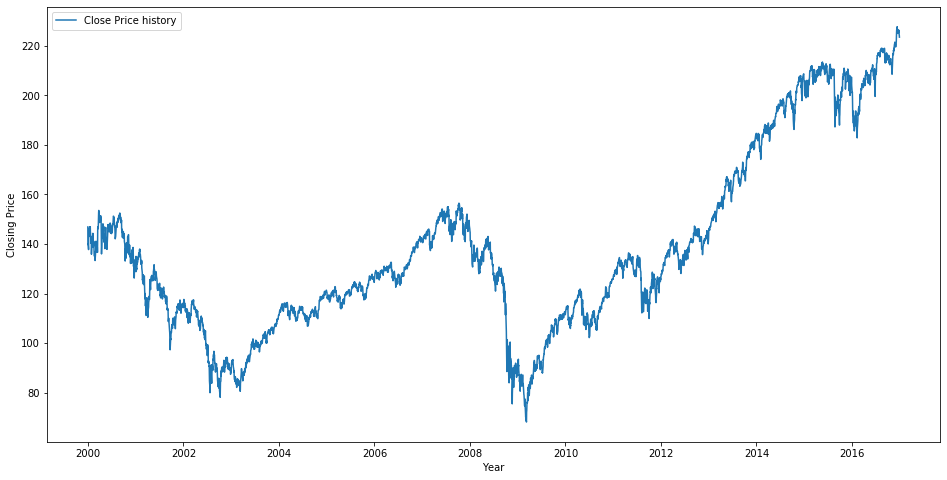

In [3]:
#setting index as date
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel("Year") 
plt.ylabel("Closing Price") 
plt.legend(loc='best')

In [4]:


#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [5]:
new_data.head()

,Date,Close
0,1999-12-31 00:00:00,146.875
1,2000-01-01 00:00:00,145.438
2,2000-01-02 00:00:00,139.75
3,2000-01-03 00:00:00,140
4,2000-01-06 00:00:00,137.75


In [6]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [7]:
#split into train and validation
train = new_data[:3419]
valid = new_data[3419:]

In [8]:
print('\n Shape of training set:')
print(train.shape)
print('\n Shape of validation set:')
print(valid.shape)


 Shape of training set:
(3419, 1)

 Shape of validation set:
(859, 1)


In [9]:
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-859+i:].sum() + sum(preds)
    b = a/859
    preds.append(b)

In [10]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
61.295808742118474


In [11]:
mape=np.mean(np.abs(preds - valid['Close'].values)/np.abs(valid['Close'].values))
mape

0.29868548275453843

In [12]:
mpe = np.mean((preds - valid['Close'].values)/valid['Close'].values)
mpe

-0.29868548275453843

C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'upper centre'. Falling back on 'best'; valid locations are
	best
	upper right
	

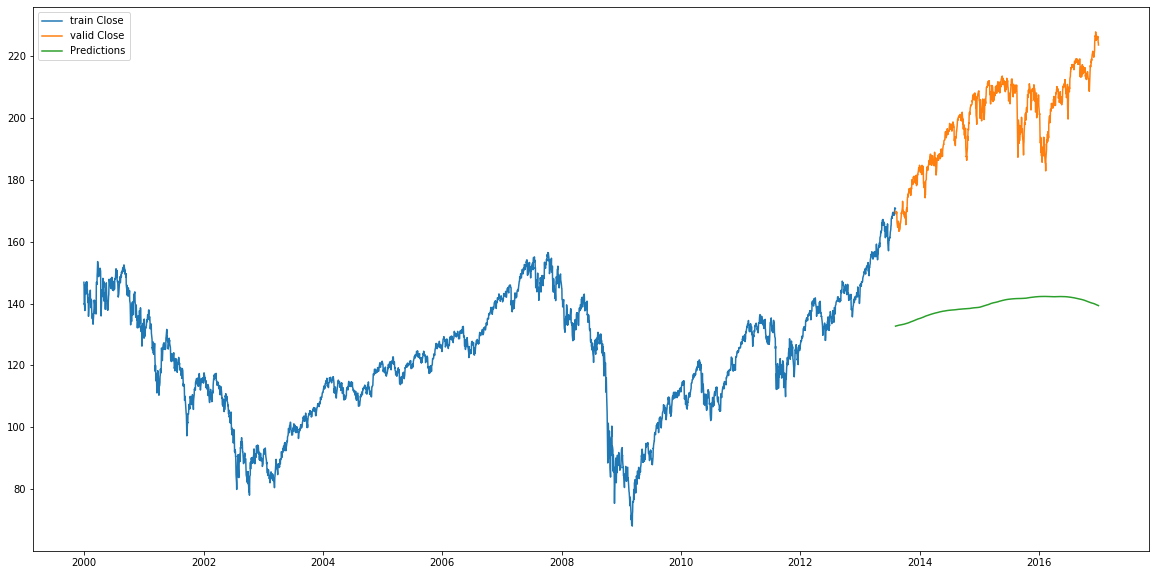

In [13]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'],label='train Close')
plt.plot(valid['Close'],label='valid Close')
plt.plot(valid['Predictions'],label='Predictions')
plt.legend(loc="upper centre")

INFERENCE

Predicted values obtained by the moving average model were not very promising as can be observed in the graph above. An R.M.S.E. of 61.295808742118474 and a M.A.P.E. of 0.29868548275453843, is to say the least, not a good performance.

## Auto ARIMA
ARIMA is an exceptionally prevalent factual strategy for time arrangement determining. ARIMA models consider the past qualities to anticipate the future qualities. There are three significant parameters in ARIMA:

     p (past values used for forecasting the next value)
     q (past forecast errors used to predict the future values)
     d (order of differencing)
 Parameter tuning for ARIMA expends a ton of time. So we will utilize auto ARIMA which consequently chooses the best blend of (p,q,d) that gives the least blunder


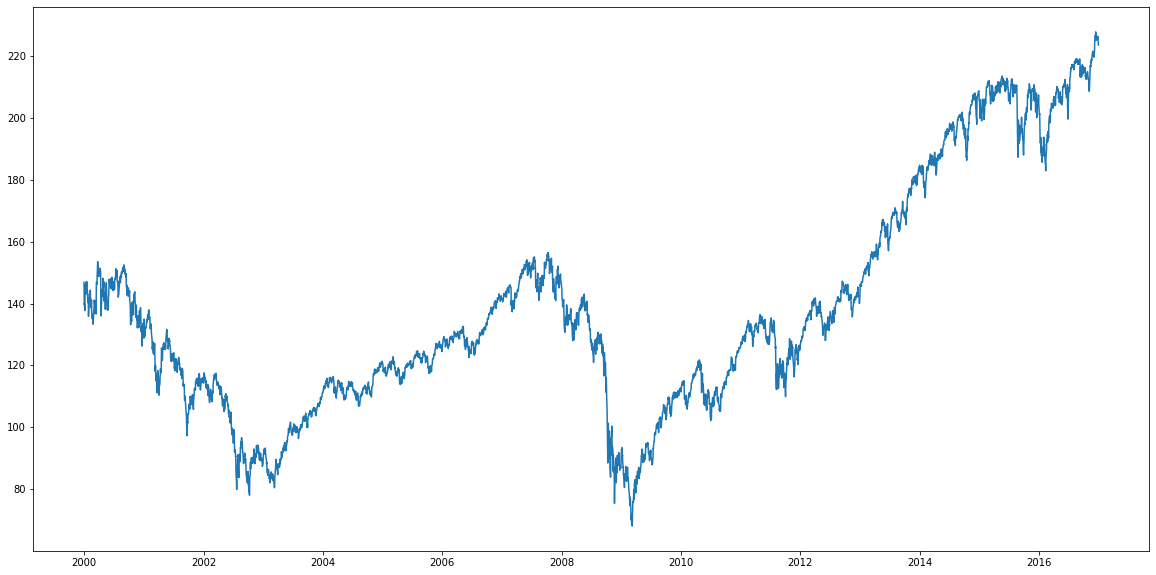

In [48]:

data = pd.read_csv("./SPY1.csv")
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
plt.plot(data['Close'])

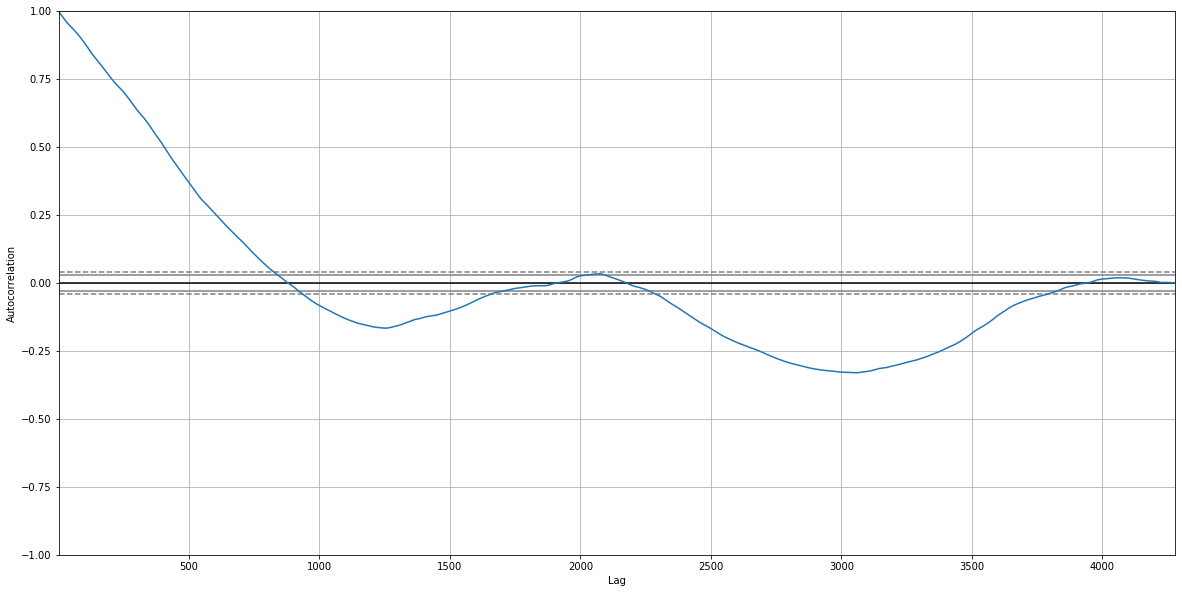

In [49]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Close'])

Looking at the data, it looks pretty not stationary. There’s no real trend in the time series but there seems to be something that might be seasonality, so we’ll dig deeper into the data.  Let’s plot a histogram to see what the underlying distribution looks like.

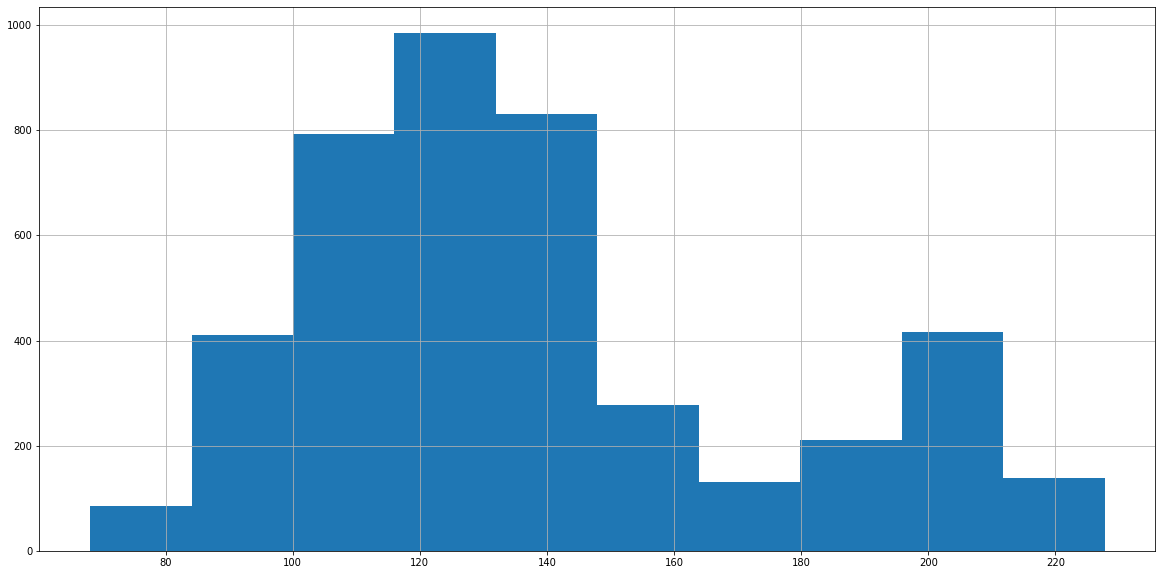

In [50]:
data['Close'].hist()

Looks Gaussian with a bit of a long tail skew toward the right. From this histogram, I’m pretty confident that we have a stationary dataset otherwise we’d see something much less ‘bell-shaped’ due to trending and/or seasonality (e.g., we’d see more data plotted to the left or right).

Now, let’s look at some statistical tests. A simple one that you can use is to look at the mean and variance of multiple sections of the data and compare them. If they are similar, your data is most likely stationary.

In [51]:
one, two, three = np.split(
        data['Close'].sample(
        frac=1), [int(.25*len(data['Close'])),
        int(.75*len(data['Close']))])

In [52]:
mean1, mean2, mean3 = one.mean(), two.mean(), three.mean()
var1, var2, var3 = one.var(), two.var(), three.var()

In [53]:
print (mean1, mean2, mean3)
print (var1, var2, var3)

137.92594005238539 137.55147034408614 138.17703038504672
1394.9378810270955 1268.266310574115 1274.6210383794535


Not great formatting, but you can quickly see that the means and variances are similar, pointing to stationary data. So…don’t rely on these only…they’re a quick way to see what i have without having to pull out the big guns and run things like the Dickey-Fuller test.

### Dickey-Fuller Test for Stationarity

In [54]:
from statsmodels.tsa.stattools import adfuller

In [55]:
adf_test = adfuller(data['Close'])
adf_test

(0.1042599074615808,
 0.9663507370998039,
 18,
 4259,
 {'1%': -3.43188633380603,
  '5%': -2.8622188674189872,
  '10%': -2.5671313664110107},
 15556.69354497428)

In [56]:
print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

ADF = 0.1042599074615808
p-value = 0.9663507370998039


Our p-value is definitely not less than 0.5 and is even less than 0.01 so we cannot say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is not stationary. Additionally, our ADF is much not less than our 1% confidence value. This will be taken care of in the model by the differencing

### Model
The hyperparamater has been taken care of my ato-arima model

In [66]:
#from pyramid.arima import auto_arima
import pmdarima as pm
#from pmdarima.arima import auto_arima
data = data.sort_index(ascending=True, axis=0)
train = data[:3419]
valid = data[3419:]
training = train['Close']
validation = valid['Close']

model =pm. auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model=model.fit(training)
print(model.summary())
forecast = model.predict(n_periods=859)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])
    
mape = np.mean(np.abs(forecast['Prediction'] - valid['Close'])/np.abs(valid['Close']))
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
mpe = np.mean((forecast['Prediction'].dropna().values  - valid['Close'].dropna().values)/valid['Close'].dropna().values)
corr = np.corrcoef(forecast['Prediction'].dropna().values, valid['Close'].dropna().values)[0,1] 

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=12466.133, BIC=12496.800, Time=16.672 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=14598.463, BIC=14610.729, Time=0.391 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=13734.423, BIC=13758.957, Time=3.892 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=12476.908, BIC=12501.441, Time=23.706 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=14596.463, BIC=14602.596, Time=0.327 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=14564.756, BIC=14589.290, Time=2.951 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=12459.278, BIC=12496.077, Time=35.097 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the bord

In [67]:
print(mape,rms,mpe,corr)

0.05854430610245008 15.776921855275106 0.03774998303691971 0.812969960047673


In [ ]:
#mape = np.mean(np.abs(forecast['Prediction'] - valid['Close'])/np.abs(valid['Close']))


In [ ]:
#rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

In [61]:
#mpe = np.mean((forecast['Prediction'].dropna().values  - valid['Close'].dropna().values)/valid['Close'].dropna().values)


In [63]:
#corr = np.corrcoef(forecast['Prediction'].dropna().values, valid['Close'].dropna().values)[0,1] 


C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'upper centre'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


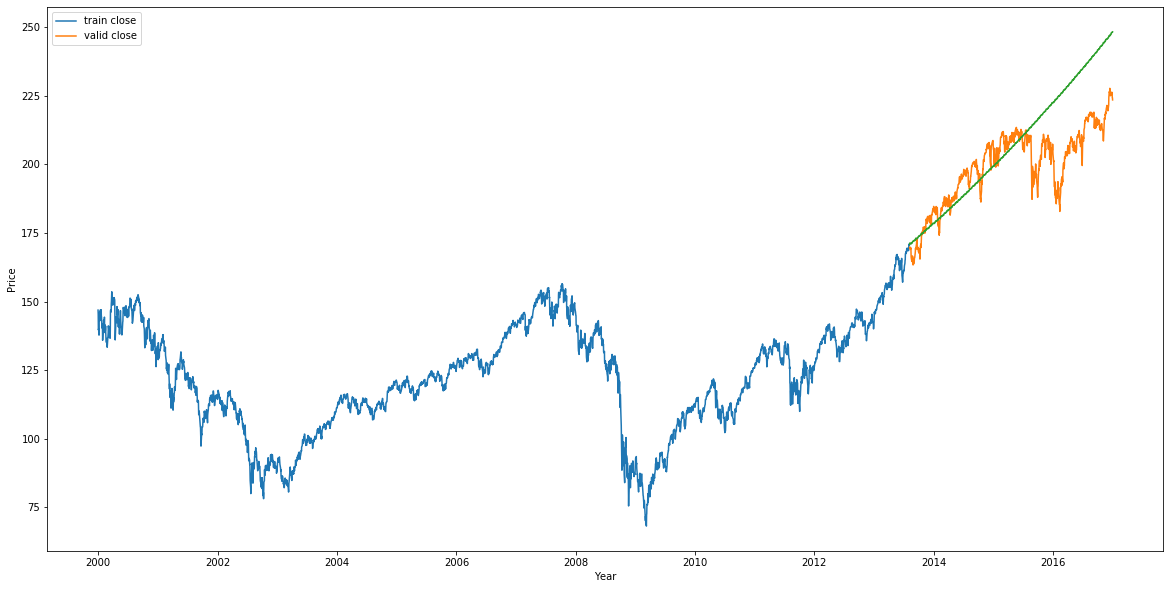

In [68]:
#plot
plt.plot(train['Close'],label='train close')
plt.plot(valid['Close'],label='valid close')
plt.plot(forecast['Prediction'])
plt.xlabel("Year") 
plt.ylabel("Price") 
plt.legend(loc="upper centre")

### INFERENCE

Predicted values obtained by both the ARIMA model were in the same range as the actual values. The ARIMA obtained very good results, achieving a M.A.P.E. of 0.05854430610245008 and an R.M.S.E. of 15.776921855275106. This was a very good performance as can be observed in the graph above.

As we saw before, an auto ARIMA model uses past information to comprehend the example in the time arrangement. Utilizing these qualities, the model caught an expanding pattern in the arrangement. In spite of the fact that the forecasts utilizing this system are far superior than that of the recently executed AI models, these expectations are as yet not near the genuine qualities. 
As its clear from the plot, the model has caught a pattern in the arrangement, however doesn't concentrate on the regular part

## Long Short Term Memory (LSTM)


Long Short-Term Memory (LSTM) networks are the gold standard to building RNN’s in practice today and they have proven to be highly effective for sequence prediction problems. They rely on gated cells to track information throughout many time steps thereby learning long-term dependencies and overcoming the vanishing gradient problem.
LSTM are a modified version of recurrent neural networks well-suited to predict time series given time lags of unknown durations. LSTM will train the model using back-propagation, and will store useful past information while forgetting any information that is not. 


In [14]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [15]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [16]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [17]:
new_data.head()

,Close
Date,
1999-12-31,146.875
2000-01-01,145.438
2000-01-02,139.75
2000-01-03,140
2000-01-06,137.75


In [18]:
#creating train and test sets
dataset = new_data.values

In [19]:
dataset.shape

(4278, 1)

In [20]:
train = dataset[0:3419,:]
valid = dataset[3419:,:]

In [21]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [22]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [23]:
x_train.shape

(3359, 60, 1)

The lists of hyperparameter are:
  * input_shape-The number of lag to be used as input to the model
  * nodes-The number of LSTM to use as hidden layer
  * Epochs-The number of times to expose the model to the training dataset
  * Batch -The number of sample within each epoch after  the weight has been updated

In [24]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 859 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

Epoch 1/1
 - 149s - loss: 6.0837e-04 - accuracy: 2.9771e-04


In [26]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


(859, 60)


C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


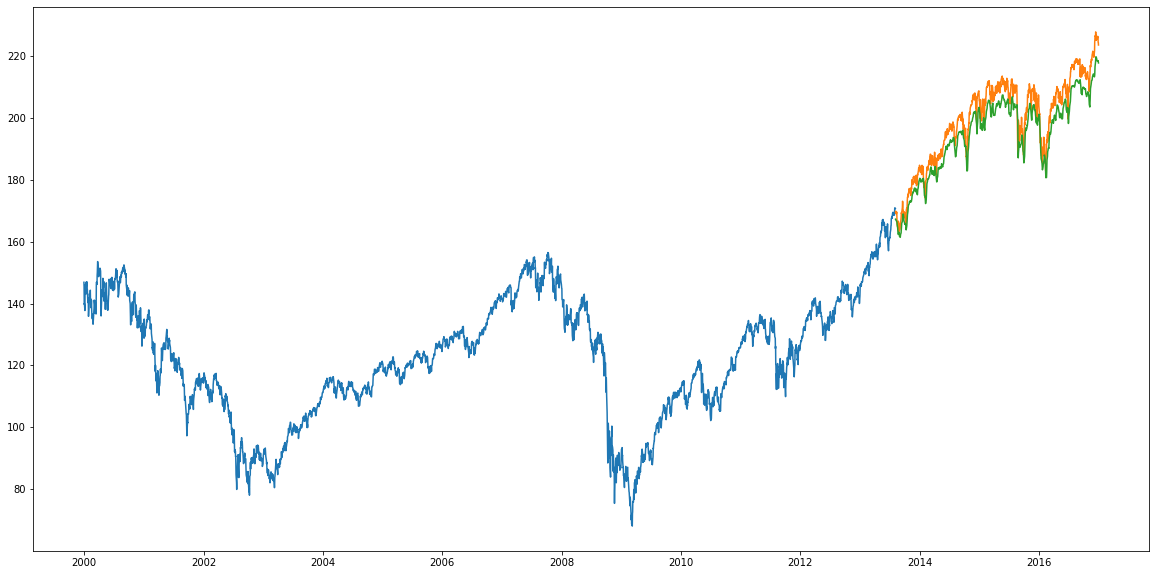

In [28]:
#for plotting
train = new_data[:3419]
valid = new_data[3419:]
valid['Predictions'] = closing_price
plt.plot(train.index,train['Close'])
plt.plot(valid.index,valid[['Close','Predictions']])
 

In [29]:
rms=np.sqrt(np.mean(np.power((valid['Close'].values-closing_price),2)))
rms

19.76439433442637

In [30]:
mape = np.mean(np.abs(closing_price - valid['Close'].values)/np.abs(valid['Close'].values))
mape

0.07966158245150375

In [31]:
mpe = np.mean(np.abs(closing_price - valid['Close'].values)/valid['Close'].values)
mpe

0.07966158245150375

### INFERENCE

Predicted values obtained by the LSTM models were in the same range as the actual values.The LSTM models obtained very good great results, achieving a M.A.P.E. of 0.07690187666147934 and an R.M.S.E. of 18.9628767142347. This was a very good performance as can be observed in the graph above.
We also observed that the LSTM model can be tuned for various parameters, for instance, changing the amount of LSTM layers, including dropout regard or growing the amount of ages. 


 ## Building the Artificial Neural Network

Artificial Neural Networks (ANN’s) use three neuron layers namely: input layer, hidden layer, and the output layers to obtain the forecasted prices. Artificial nodes or neurons are the main processing elements of artificial neural networks. The synapses are related to input signals and show connection weights. The weighted sum of the input signals represents the neuron impulse and is computed then transformed using a transfer function. A transfer function defines the neurons nonlinear characteristics. The neuron is able to obtain its learning capability by setting the weights according to the chosen learning algorithm

In [32]:
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout

In [33]:
train = data[:3419]
valid = data[3419:]

In [34]:
x_train1, y_train1 = [], []
for i in range(60,len(train)):
    x_train1.append(scaled_data[i-60:i,0])
    y_train1.append(scaled_data[i,0])
x_train1, y_train1 = np.array(x_train1), np.array(y_train1)

x_train1 = np.reshape(x_train1, (x_train1.shape[0],x_train1.shape[1]))

In [35]:
x_train1.shape

(3359, 60)

In [36]:
model1 = Sequential()
model1.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = 60))

In [37]:
model1.add(Dense(units =128, kernel_initializer = 'uniform', activation      = 'relu'))

In [38]:
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation        = 'sigmoid'))


In [39]:
model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics 
         = ['accuracy'])

In [40]:
model1.fit(x_train1, y_train1, batch_size = 1, epochs =50,verbose=2)

Epoch 1/50
 - 5s - loss: 0.0039 - accuracy: 2.9771e-04
Epoch 2/50
 - 5s - loss: 5.8511e-04 - accuracy: 2.9771e-04
Epoch 3/50
 - 5s - loss: 4.9699e-04 - accuracy: 2.9771e-04
Epoch 4/50
 - 6s - loss: 4.8927e-04 - accuracy: 2.9771e-04
Epoch 5/50
 - 6s - loss: 4.3850e-04 - accuracy: 2.9771e-04
Epoch 6/50
 - 5s - loss: 3.5243e-04 - accuracy: 2.9771e-04
Epoch 7/50
 - 5s - loss: 3.2129e-04 - accuracy: 2.9771e-04
Epoch 8/50
 - 5s - loss: 3.1934e-04 - accuracy: 2.9771e-04
Epoch 9/50
 - 5s - loss: 2.9335e-04 - accuracy: 2.9771e-04
Epoch 10/50
 - 5s - loss: 2.7906e-04 - accuracy: 2.9771e-04
Epoch 11/50
 - 5s - loss: 2.7942e-04 - accuracy: 2.9771e-04
Epoch 12/50
 - 5s - loss: 2.7636e-04 - accuracy: 2.9771e-04
Epoch 13/50
 - 5s - loss: 2.4652e-04 - accuracy: 2.9771e-04
Epoch 14/50
 - 5s - loss: 2.4983e-04 - accuracy: 2.9771e-04
Epoch 15/50
 - 5s - loss: 2.4196e-04 - accuracy: 2.9771e-04
Epoch 16/50
 - 5s - loss: 2.1472e-04 - accuracy: 2.9771e-04
Epoch 17/50
 - 5s - loss: 2.5367e-04 - accuracy: 2.97

In [41]:
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               7808      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
#predicting 859 values, using past 60 from the train data
inputs1 = new_data[len(new_data) - len(valid) - 60:].values
inputs1 = inputs1.reshape(-1,1)
inputs1  = scaler.transform(inputs1)

In [43]:
X_test1 = []
for i in range(60,inputs1.shape[0]):
    X_test1.append(inputs1[i-60:i,0])
X_test1 = np.array(X_test1)
print(X_test1.shape)
X_test1 = np.reshape(X_test1, (X_test1.shape[0],X_test1.shape[1]))
X_test1.shape
closing_price1 = model1.predict(X_test1)
closing_price1 = scaler.inverse_transform(closing_price1)

(859, 60)


In [44]:
rms=np.sqrt(np.mean(np.power((valid['Close'].values-closing_price1),2)))
rms

35.46746812458451

In [45]:
mape = np.mean(np.abs(closing_price1 - valid['Close'].values)/np.abs(valid['Close'].values))
mape

0.15939624322030904

In [46]:
mpe = np.mean(np.abs(closing_price1 - valid['Close'].values)/valid['Close'].values)
mpe

0.15939624322030904

C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\OSAGIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'upper centre'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


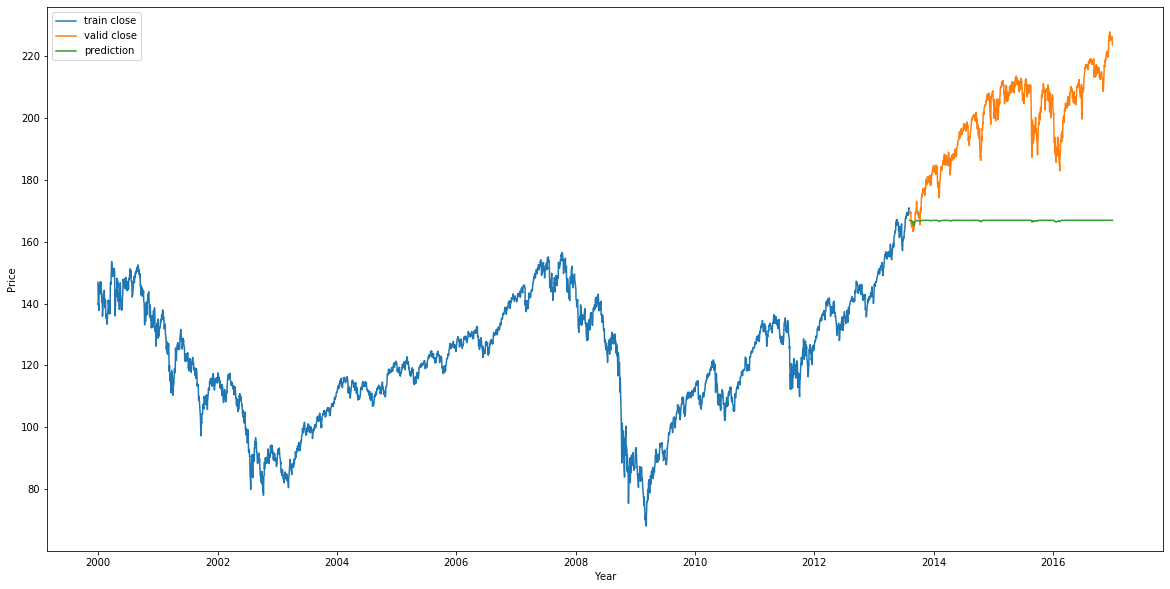

In [47]:
#for plotting
train = new_data[:3419]
valid = new_data[3419:]
valid['Predictions'] = closing_price1
plt.plot(train['Close'],label='train close')
plt.plot(valid['Close'],label='valid close')
plt.plot(valid['Predictions'],label='prediction')
plt.xlabel("Year") 
plt.ylabel("Price") 
plt.legend(loc="upper centre")

### INFERENCE

With an M.A.P.E. of 0.15939624322030904 and an R.S.M.E. of 35.46746812458451, the ANN performed better as compared with the moving average, but was also not good enough as can be observed in the graph above We can safely say that ANN has not performed well on this dataset.

### Conclusion

Machine learning and deep learning techniques have the potential to ease the whole processes of analysing large chunks of data, spotting significant patterns and generating a single output that navigates traders towards a particular decision based on predicted asset prices.
We recognize that many financial engineers and other researchers are spending sleepless nights trying to improve the performance of machine learning and deep learning models. We propose to open source our architecture to give an opportunity to likeminded engineers and researchers to contribute to the improvement of this code and to encourage collaboration and continual improvement. 
Finally, it is important to note that stock prices can be affected by many other highly interrelated factors that include company-specific variables, political, economic, and psychological. Natural factors like climate change, drought, hurricanes, floods, earthquakes and other factors like demonetization or merger/demerger of the organizations could also affect stock prices. Many of these factors can be difficult to anticipate and may need additional tools to properly forecast their effects.


In [69]:
pwd

'C:\\Users\\OSAGIE\\Desktop\\Dataset\\information library\\Final Project\\Final Project'

In [ ]:
'c:\\users\\osagie\\anaconda3\\envs\\catalyst\\lib\\site-packages\\ipykernel_launcher.py'

In [ ]:
sys.argv[0]